In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import ast
import json
import numpy as np
import os
import re
from sklearn.linear_model import LinearRegression

# Read runtimes from logfiles

In [3]:
def read_all_logfiles_in_directory(logfile_directory):
    runtimes = {}
    for logfile_name in os.listdir(logfile_directory):
        model = logfile_name.replace(".log", "")
        logfile_full_path = os.path.join(logfile_directory, logfile_name)
        with open(logfile_full_path, 'r') as f:
            for line in f:
                m = re.match(r'Runtime for (.*): (\d+\.\d+) seconds', line)
                if m is not None:
                    label = ast.literal_eval(m.group(1))
                    label['model'] = model
                    runtime = float(m.group(2))
                    # Account for the fact that we only profiled 1/3rd of the layers
                    # in the Megatron-Turing NLG model.
                    if model == "mt_nlg":
                        runtime *= 3
                    runtimes[(label['model'], label['num_input_tokens'],
                              label['num_output_tokens'])] = runtime
    return runtimes

In [4]:
v100_runtimes = read_all_logfiles_in_directory("../logs/v100")
a100_runtimes = read_all_logfiles_in_directory("../logs/a100")

In [5]:
import csv
def read_logfile(logfile, collect_runtime_discrepancy=False):
    runtimes = {}
    header = None
    with open(logfile, 'r') as f:
        for line in csv.reader(f, delimiter=','):
            if header is None:
                header = line
            else:
                runtime_dict = {}
                for (header_elem, line_elem) in zip(header, line):
                    if header_elem == 'scenario':
                        scenario_tokens = line_elem.split(",")
                        model, num_input_tokens_intended, num_output_tokens_intended = \
                            None, None, None
                        for scenario_token in scenario_tokens:
                            if scenario_token.startswith("model="):
                                model = scenario_token.replace("model=", "").replace("-", "_")
                            elif scenario_token.startswith("num_input_tokens="):
                                num_input_tokens_intended = \
                                    int(scenario_token.replace("num_input_tokens=", ""))
                            elif scenario_token.startswith("num_output_tokens="):
                                num_output_tokens_intended = \
                                    int(scenario_token.replace("num_output_tokens=", ""))
                    elif header_elem == 'inference_runtime':
                        if line_elem == '':
                            inference_runtime = None
                        else:
                            inference_runtime = float(line_elem)
                    elif header_elem == 'inference_runtime_discrepancy':
                        if line_elem == '':
                            inference_runtime_discrepancy = None
                        else:
                            inference_runtime_discrepancy = float(line_elem)
                    elif header_elem == 'num_prompt_tokens':
                        num_input_tokens = int(line_elem)
                    elif header_elem == 'num_output_tokens':
                        num_output_tokens = int(line_elem)
                if collect_runtime_discrepancy:
                    if inference_runtime_discrepancy is not None:
                        runtimes[(model, num_input_tokens, num_output_tokens)] = inference_runtime_discrepancy
                else:
                    if inference_runtime is not None:
                        runtimes[(model, num_input_tokens, num_output_tokens)] = inference_runtime
    return runtimes

In [6]:
import json
def read_real_logdir(parent_dir):
    all_runtimes = {}
    for sub_dir in os.listdir(parent_dir):
        m = re.match(r'synthetic_efficiency:.*,num_input_tokens=(\d+),'
                     r'num_output_tokens=(\d+),.*,model=(.*)', sub_dir)
        if m is not None:
            num_input_tokens = int(m.group(1))
            num_output_tokens = int(m.group(2))
            model = m.group(3).replace("-", "_")
            
            full_logpath = os.path.join(parent_dir, sub_dir, "per_instance_metrics.json")
            try:
                with open(full_logpath, 'r') as f:
                    metrics = json.load(f)
                    runtimes = []
                    for instance, metrics in metrics.items():
                        for metric in metrics:
                            if metric["name"]["name"] == "inference_runtime":
                                runtimes.append(metric["values"][0])
                    all_runtimes[(model, num_input_tokens, num_output_tokens)] = min(runtimes)
            except:
                pass
        
    return all_runtimes

In [7]:
real_system_runtimes = read_logfile("../logs/inference_runtimes_07-11.csv")
real_system_runtimes_v2 = read_logfile("../logs/inference_runtimes_07-19.csv")
real_system_runtime_discrepancies_v2 = read_logfile("../logs/inference_runtimes_07-11.csv",
                                                    collect_runtime_discrepancy=True)
real_system_min_runtimes = read_real_logdir("../benchmark_output/runs/ai21")

# Plot runtimes versus number of output tokens to verify linearity

In [8]:
def plot_per_model_runtimes(runtimes, model, all_num_input_tokens,
                            scatter=False, runtime_per_output_token=None,
                            ylabel=None,
                            output_filename=None):
    print(model)

    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    markers = ['+', 'D', 's', 'o']
    for marker, num_input_tokens in zip(markers, all_num_input_tokens):
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_input_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        num_output_tokens_and_runtimes.sort()
        if scatter:
            ax.scatter([x for (x, _) in num_output_tokens_and_runtimes],
                       [y for (_, y) in num_output_tokens_and_runtimes],
                       label=f"{num_input_tokens}",
                       marker=marker)
            if runtime_per_output_token is not None:
                intercept = num_output_tokens_and_runtimes[0][1]
                ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                        [intercept + ((x - 1) * runtime_per_output_token)
                         for (x, _) in num_output_tokens_and_runtimes], linestyle=':')
        else:
            ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                    [y for (_, y) in num_output_tokens_and_runtimes],
                    label=f"{num_input_tokens}",
                    marker='o')
            
    ax.set_xticks([1, 4, 8, 16, 32, 48, 64])
    
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel("Number of output tokens")
    if ylabel is None:
        ax.set_ylabel("Runtime (seconds)")
    else:
        ax.set_ylabel(ylabel)
    plt.legend(frameon=False, ncol=2)
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    
    plt.show()

# Get best-fit lines (slope and intercept)

In [9]:
import numpy as np

model_name_mapping = {
    "gptj_6b": ["huggingface/gptj_6b", "gooseai/gpt-j-6b"],
    "gpt_neox_20b": ["gooseai/gpt-neo-20b"],
    "openai_ada": ["openai/ada", "openai/text-ada-001"],
    "openai_davinci": ["openai/davinci", "openai/text-davinci-001", "openai/text-davinci-002"],
    "ai21_j1_large": ["ai21/j1-large", "openai/curie", "openai/text-curie-001"],
    "ai21_j1_grande": ["ai21/j1-grande"],
    "ai21_j1_jumbo": ["ai21/j1-jumbo"],
    "gpt2": ["huggingface/gpt2"],
    "mt_nlg": ["microsoft/TNLGv2_530B"],
    "anthropic": ["anthropic/stanford-online-helpful-v4-s3"]
}

model_parameter_mapping = {
    # (hidden_size, num_layers, gpus).
    "gptj_6b": (4096, 28, 1),
    "gpt_neox_20b": (6144, 44, 1),
    "openai_ada": (1024, 24, 1),
    "openai_davinci": (12288, 96, 8),
    "ai21_j1_large": (4096, 32, 1),
    "ai21_j1_grande": (6144, 44, 1),  # TODO: This needs to be fixed.
    "ai21_j1_jumbo": (13824, 76, 8),
    "gpt2": (4096, 48, 1),
    "mt_nlg": (20480, 105, 8),
    "anthropic": (8192, 64, 4),
}

VOCAB_SIZE = 50304

def compute_best_fit(runtimes, models, filename=None):
    json_obj = {}
    runtimes_per_output_token = {}
    for model in models:
        model_obj = {}
        model.replace("-", "_")
        
        # Get all unique num_input_tokens.
        all_num_input_tokens = set()
        for label in runtimes:
            all_num_input_tokens.add(label[1])
        all_num_input_tokens = sorted(list(all_num_input_tokens))
        
        # Group runtimes by num_input_tokens.
        processed_runtimes = [[] for num_input_tokens in all_num_input_tokens]
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_input_tokens:
                    processed_runtimes[i].append((label[2], runtime))
            processed_runtimes[i].sort()
                    
        # Cost of embedding num_input_tokens is just the runtime when
        # num_output_tokens is equal to 1.
        runtime_for_input_tokens = {}
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            assert processed_runtimes[i][0][0] == 1
            runtime_for_input_tokens[num_input_tokens] = round(processed_runtimes[i][0][1], 3)
            
        (hidden_size, num_layers, num_gpus_for_model) = model_parameter_mapping[model]

        # Perform regression between adjusted runtimes (end-to-end
        # runtime minus embedding runtime with num_input_tokens) and
        # number of output tokens, to obtain the runtime per generated
        # output token.
        num_output_tokens_and_runtimes = []
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_input_tokens:
                    num_output_tokens_and_runtimes.append(
                        (label[2], runtime - runtime_for_input_tokens[num_input_tokens]))
        X = [[x] for (x, _) in num_output_tokens_and_runtimes]
        Y = [y for (_, y) in num_output_tokens_and_runtimes]
        reg = LinearRegression()
        reg.fit(X, Y)
        print(f"R^2 score: {reg.score(X, Y):.3f}")
        runtime_per_output_token = round(reg.coef_[0], 3)
        runtimes_per_output_token[model] = runtime_per_output_token

        num_compute_operations = 24 * hidden_size**2 * num_layers
        throughput = num_compute_operations / (
            runtime_per_output_token * 10**12 * num_gpus_for_model)
        print(f"{model}:\n\tRuntime per output token = {runtime_per_output_token:.3f} seconds, "
              f"throughput = {throughput:.3f} TFLOP/s/GPU\n")
        model_obj['runtime_per_output_token'] = runtime_per_output_token
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            num_compute_operations = \
                24 * num_input_tokens * hidden_size**2 * num_layers * (
                1. + (num_input_tokens / (6 * hidden_size)) + (
                    VOCAB_SIZE / (16. * num_layers * hidden_size)))
            runtime = runtime_for_input_tokens[num_input_tokens]
            throughput = num_compute_operations / (
                runtime * 10**12 * num_gpus_for_model)
            print(f"\tRuntime for {num_input_tokens} input token(s) = {runtime:.3f} seconds, "
                  f"throughput = {throughput:.3f} TFLOP/s/GPU")
        print()
        
        square_errors = []
        for i, num_input_tokens in enumerate(all_num_input_tokens):
            for label, runtime in runtimes.items():
                if label[0] == model and label[1] == num_input_tokens:
                    estimated_runtime = runtime_for_input_tokens[num_input_tokens] + (
                        (label[2] - 1) * runtime_per_output_token)
                    square_errors.append((runtime - estimated_runtime)**2)
        print(f"\tMean squared error: {np.mean(square_errors):.4f}")
        print(f"\tMaximum squared error: {max(square_errors):.4f}")
        print()

        model_obj['runtime_for_input_tokens'] = runtime_for_input_tokens
        for model_name in model_name_mapping[model]:
            json_obj[model_name] = model_obj
    print("=" * 100)
    print()
    
    if filename is not None:
        with open(filename, 'w') as f:
            json.dump(json_obj, f, indent=2)
            
    return runtimes_per_output_token

In [10]:
# Compute best fit for A100 runtimes.
megatron_models = ["openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo",
          "gptj_6b", "gpt_neox_20b", "gpt2", "mt_nlg", "anthropic"]
real_system_models = ["ai21_j1_large", "ai21_j1_grande", "ai21_j1_jumbo"]
runtimes_per_output_token = \
    compute_best_fit(a100_runtimes, megatron_models,
                    filename="../processed_jsons/inference_efficiency.json")
real_system_min_runtimes_per_output_token = \
    compute_best_fit(real_system_min_runtimes, real_system_models)

R^2 score: 1.000
openai_ada:
	Runtime per output token = 0.019 seconds, throughput = 0.032 TFLOP/s/GPU

	Runtime for 1 input token(s) = 0.020 seconds, throughput = 0.034 TFLOP/s/GPU
	Runtime for 16 input token(s) = 0.021 seconds, throughput = 0.520 TFLOP/s/GPU
	Runtime for 32 input token(s) = 0.020 seconds, throughput = 1.095 TFLOP/s/GPU
	Runtime for 64 input token(s) = 0.020 seconds, throughput = 2.200 TFLOP/s/GPU
	Runtime for 128 input token(s) = 0.021 seconds, throughput = 4.229 TFLOP/s/GPU
	Runtime for 192 input token(s) = 0.021 seconds, throughput = 6.401 TFLOP/s/GPU
	Runtime for 256 input token(s) = 0.022 seconds, throughput = 8.220 TFLOP/s/GPU
	Runtime for 320 input token(s) = 0.023 seconds, throughput = 9.916 TFLOP/s/GPU
	Runtime for 384 input token(s) = 0.023 seconds, throughput = 12.004 TFLOP/s/GPU
	Runtime for 428 input token(s) = 0.024 seconds, throughput = 12.899 TFLOP/s/GPU
	Runtime for 472 input token(s) = 0.024 seconds, throughput = 14.310 TFLOP/s/GPU
	Runtime for 512 i

openai_davinci


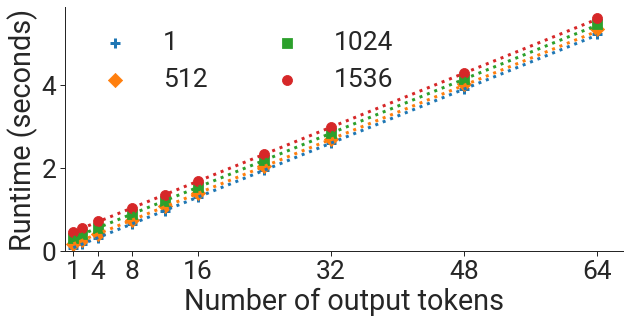

ai21_j1_jumbo


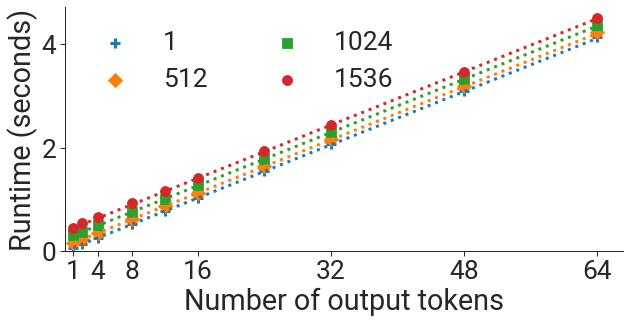

mt_nlg


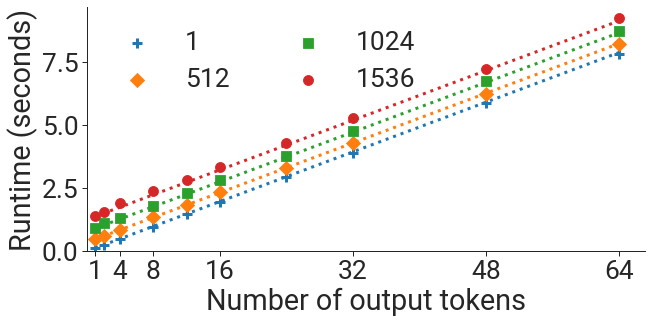

anthropic


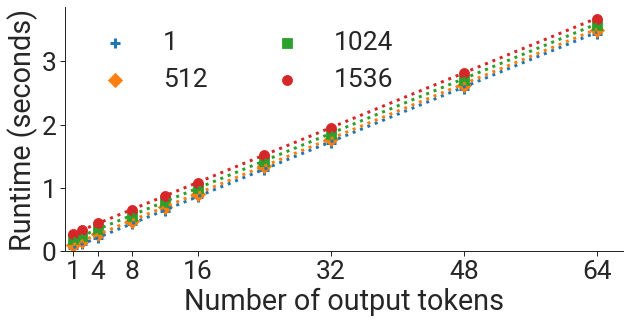

In [11]:
# Plot A100 runtimes.
plot_per_model_runtimes(a100_runtimes, 'openai_davinci', [1, 512, 1024, 1536],
                        scatter=True,
                        runtime_per_output_token=runtimes_per_output_token['openai_davinci'],
                        output_filename='../figures/runtime_vs_num_output_tokens/openai_davinci.pdf')
plot_per_model_runtimes(a100_runtimes, 'ai21_j1_jumbo', [1, 512, 1024, 1536],
                        scatter=True,
                        runtime_per_output_token=runtimes_per_output_token['ai21_j1_jumbo'],
                        output_filename='../figures/runtime_vs_num_output_tokens/ai21_j1_jumbo.pdf')
plot_per_model_runtimes(a100_runtimes, 'mt_nlg', [1, 512, 1024, 1536],
                        scatter=True,
                        runtime_per_output_token=runtimes_per_output_token['mt_nlg'],
                        output_filename='../figures/runtime_vs_num_output_tokens/mt_nlg.pdf')
plot_per_model_runtimes(a100_runtimes, 'anthropic', [1, 512, 1024, 1536],
                        runtime_per_output_token=runtimes_per_output_token['anthropic'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/anthropic.pdf')

Minimum
ai21_j1_large


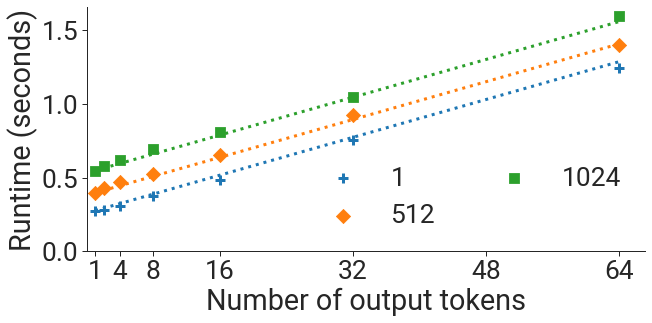

ai21_j1_grande


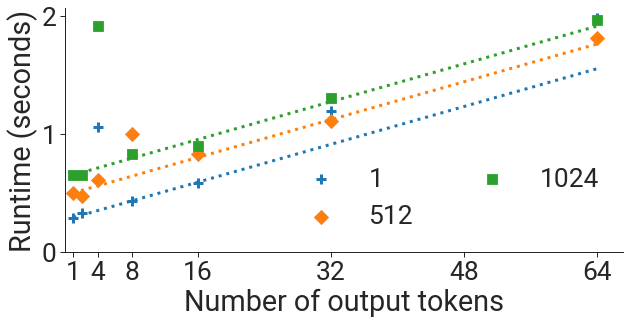

ai21_j1_jumbo


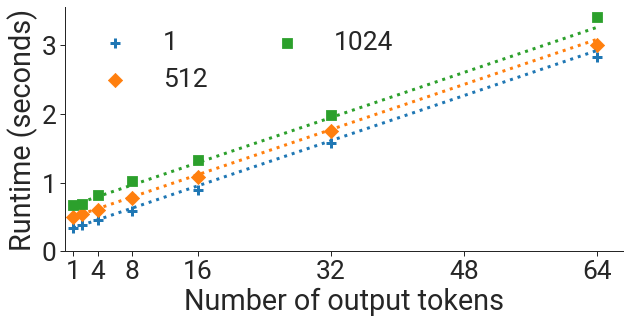

In [12]:
print("Minimum")
plot_per_model_runtimes(real_system_min_runtimes, 'ai21_j1_large', [1, 512, 1024],
                        runtime_per_output_token=real_system_min_runtimes_per_output_token['ai21_j1_large'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_large_v3.pdf')
plot_per_model_runtimes(real_system_min_runtimes, 'ai21_j1_grande', [1, 512, 1024],
                        runtime_per_output_token=real_system_min_runtimes_per_output_token['ai21_j1_grande'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_grande_v3.pdf')
plot_per_model_runtimes(real_system_min_runtimes, 'ai21_j1_jumbo', [1, 512, 1024],
                        runtime_per_output_token=real_system_min_runtimes_per_output_token['ai21_j1_jumbo'],
                        scatter=True, output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_jumbo_v3.pdf')